# Field Significance

## Introduction
In atmospheric and oceanic sciences, we are often interested in trends of a gridded variable. There are a number of ways the computation and interpretation of these trends can differ from trends from a *single* variable in *one* location. This notebook aims to be a short guide to the problem of field significance, which is still often ignored in many studies and can lead to overstatement of the scientific results. Here, a short summary is presented of the work from Wilks, 2016 and DelSole and Tippett 2022, in addition to some code to compute the **False Discovery Rate**, a simple test which can address the field significance problem. 

### Sources
- Wilks, D. S. (2016). “The Stippling Shows Statistically Significant Grid Points”: How Research Results are Routinely Overstated and Overinterpreted, and What to Do about It, Bulletin of the American Meteorological Society, 97(12), 2263-2273. Retrieved Jan 24, 2023, from https://journals.ametsoc.org/view/journals/bams/97/12/bams-d-15-00267.1.xml
- DelSole, T., & Tippett, M. (2022). Field Significance. In Statistical Methods for Climate Scientists (pp. 298-313). Cambridge: Cambridge University Press. doi:10.1017/9781108659055.014

## Contents
- [**Introduction**](#Introduction)
- [**Trend Estimation**](#Linear-Trend-Estimation-using-Least-Squares)
- [**Hypothesis testing**](#Hypothesis-testing)
- [**Field Significance**](#Field-Significance)
    - [**False Discovery Rate**](#False-Discovery-Rate)
<!--     - **Livezey-Chen test** -->
<!--     - **Linear regression test** -->

In [1]:
import xarray as xr
import numpy as np
from scipy import stats

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import cmocean

In [2]:
projection=ccrs.Stereographic(central_longitude=180)
region=(155,205,45,68)

### Dataset
We use an ERA5 dataset of the 99th percentile of the 10-meter wind speed over the Bering Sea in winter (October - April). It covers the period from 2002/2003 - 2021/2022.

In the figure below we see the 99th percentile for the winter of 2002/2003

In [3]:
ds = xr.open_dataset('data/wind_trend_winter_99th.nc')

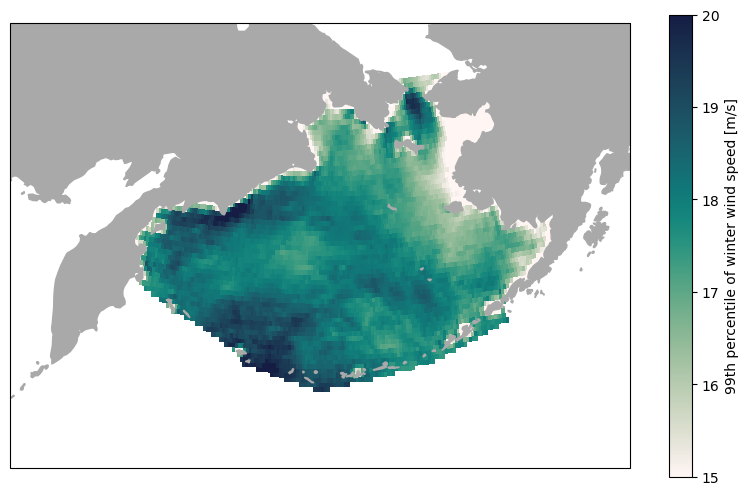

In [4]:
C = ds['windspeed_99'].sel(time=2003)

fig = plt.figure(figsize=(10,6))
ax=plt.axes(projection=projection)
ax.set_extent(region)
pc=ax.pcolormesh(ds['longitude'],ds['latitude'], C, cmap='cmo.tempo', shading='auto', vmin=15, vmax=20, transform=ccrs.PlateCarree())
ax.add_feature(cfeature.LAND, zorder=2, color='darkgrey')
fig.colorbar(pc, label='99th percentile of winter wind speed [m/s]')

## Linear Trend Estimation using Least Squares
We are interested in the trend of this quantity over the 20 years of our data. We can estimate that using a number of different methods, but here we will use the most common one, which is the linear trend using a least-squares method (see [Mann-Kendall test and Sen's slope](https://vsp.pnnl.gov/help/vsample/design_trend_mann_kendall.htm) for another way). To calculate the linear trend using an ordinary least squares method, there are a number of options:
- numpy
    - by hand: slope = sum((X-mean(X) * (Y-mean(Y)) / sum((X-mean(X))^2)
    - [numpy polyfit](https://numpy.org/doc/stable/reference/generated/numpy.polyfit.html)
- [scipy.linregress](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.linregress.html)
    - **Advantage**: also does the hypothesis test for you
    - **Disadvantage**: not vectorized: need a for-loop
- [statsmodels.OLS](https://www.statsmodels.org/dev/generated/statsmodels.regression.linear_model.OLS.html)

#### scipy.linregress
Here we use the scipy.linregress method to compute the 20 year trend for every gridpoint. We use it here because it also computes the p-values for a two-sided hypothesis test (Wald test) by default. We will use these in the next section to look at the significance of the trend. 

In [5]:
x = ds['time'].values
y = ds['windspeed_99'].values

n = y.shape[1]
m = y.shape[2]

print(f'The wind speed y has a shape of {y.shape[0]} x {n} x {m}')
print(f'{y.shape[0]} is the length of the time range we want to compute the trend over')
print(f'That means that we have n x m = {n*m} gridpoints at which we want to compute that trend')

The wind speed y has a shape of 20 x 66 x 175
20 is the length of the time range we want to compute the trend over
That means that we have n x m = 11550 gridpoints at which we want to compute that trend


##### Compute the trend and the p-values

In [6]:
slopes = np.zeros((n,m))
intercepts = np.zeros((n,m))
std_errs = np.zeros((n,m))
p_values = np.zeros((n,m))

for i in range(n):
    for j in range(m):
        slope, intercept, r_value, p_value, std_err = stats.linregress(x, y[:,i,j])
        slopes[i,j] = slope     # m/s/year
        std_errs[i,j] = std_err # m/s/year
        intercepts[i,j] = intercept
        p_values[i,j] = p_value

##### Plot the trend

In [7]:
maxid = np.unravel_index(np.nanargmax(slopes), slopes.shape)
minid = np.unravel_index(np.nanargmin(slopes), slopes.shape)

In [8]:
y_max = y[:,maxid[0],maxid[1]]
y_hat_max = slopes[maxid]*x+intercepts[maxid]

In [70]:
(x-np.mean(x))*(y_max-np.mean(y_max))

array([15.62306499, 10.12910938, -0.51702976,  4.85870934, 11.39305496,
        0.87749863,  1.57256603, -0.86292267, -1.76390934, -0.45693398,
       -0.13847446, -1.35033417, -2.15567112,  1.03719997,  0.31121349,
       10.10151672,  5.57945347,  8.4637928 , 11.7060957 ,  2.55349827])

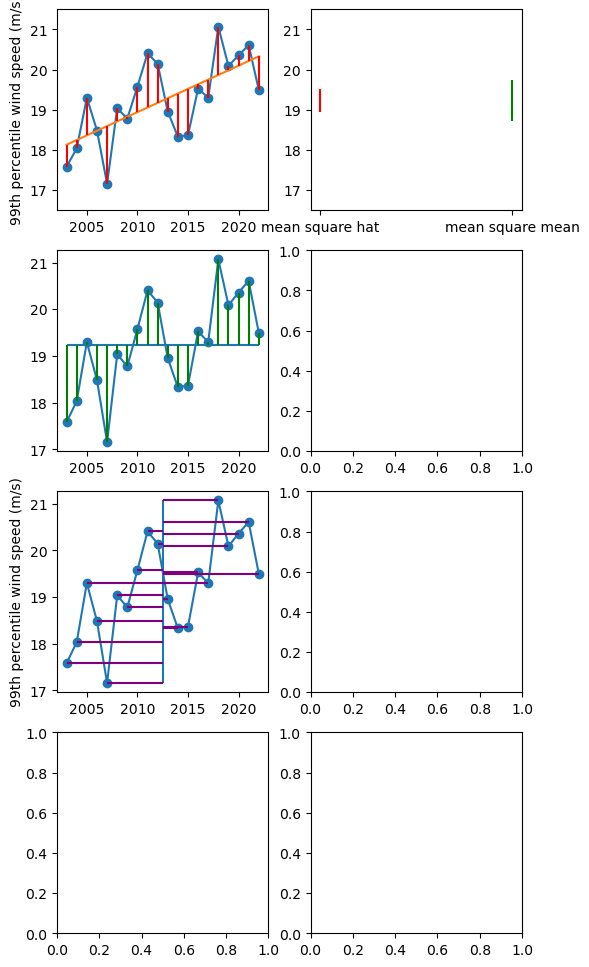

In [69]:
fig, ((ax1,ax2),(ax3,ax4),(ax5,ax6),(ax7,ax8))=plt.subplots(nrows=4,ncols=2, figsize=(6,12))
ax1.scatter(x,y_max)
ax1.plot(x,y_max)
ax1.plot(x,y_hat_max, color='tab:orange')
for j in range(len(x)):
    ax1.vlines(x[j], np.min([y_max[j],y_hat_max[j]]), np.max([y_max[j],y_hat_max[j]]),color='red')
ax1.set_ylabel('99th percentile wind speed (m/s)')
ax1.set_ylim(16.5,21.5)
# ax1.set_xlabel('Year')
# ax1.xticks(np.arange(2002,2023,5))

ax2.vlines(0,np.mean(y_max)-0.5*np.mean(np.square(y_max-y_hat_max)),np.mean(y_max)+0.5*np.mean(np.square(y_max-y_hat_max)),color='red')
ax2.vlines(1,np.mean(y_max)-0.5*np.mean(np.square(y_max-np.mean(y_max))),np.mean(y_max)+0.5*np.mean(np.square(y_max-np.mean(y_max))),color='green')
# ax2.vlines(1,np.mean(y_max)-0.5*np.sum(np.square(y_max-y_hat_max)),np.mean(y_max)+0.5*np.sum(np.square(y_max-y_hat_max)),color='red')
# ax2.vlines(1,np.mean(y_max),np.sum(np.square(y_max-y_hat_max))+0.5*np.mean(y_max),color='red')
ax2.set_ylim(16.5,21.5)
ax2.set_xticks([0,1])
ax2.set_xticklabels(['mean square hat','mean square mean'])

ax3.scatter(x,y_max)
ax3.plot(x,y_max)
ax3.hlines(np.mean(y_max),np.min(x),np.max(x))
for j in range(len(x)):
    ax3.vlines(x[j], np.min([y_max[j],np.mean(y_max)]), np.max([y_max[j],np.mean(y_max)]),color='green')
# ax2.set_ylabel('99th percentile wind speed (m/s)')
# ax2.set_xlabel('Year')
# ax2.set_xticks(np.arange(2002,2023,5))

ax5.scatter(x,y_max)
ax5.plot(x,y_max)
ax5.vlines(np.mean(x),np.min(y_max),np.max(y_max))
for j in range(len(x)):
    ax5.hlines(y_max[j], np.min([x[j],np.mean(x)]), np.max([x[j],np.mean(x)]),color='purple')
ax5.set_ylabel('99th percentile wind speed (m/s)')
# ax2.set_xlabel('Year')
# ax2.set_xticks(np.arange(2002,2023,5))

# ax4.

plt.show()

In [10]:
da_trend = xr.DataArray(data=slopes*10, # m/s/decade
                        dims=["latitude", "longitude"],
                        coords=dict(longitude=("longitude",ds["longitude"].data),
                                    latitude=("latitude",ds["latitude"].data)))

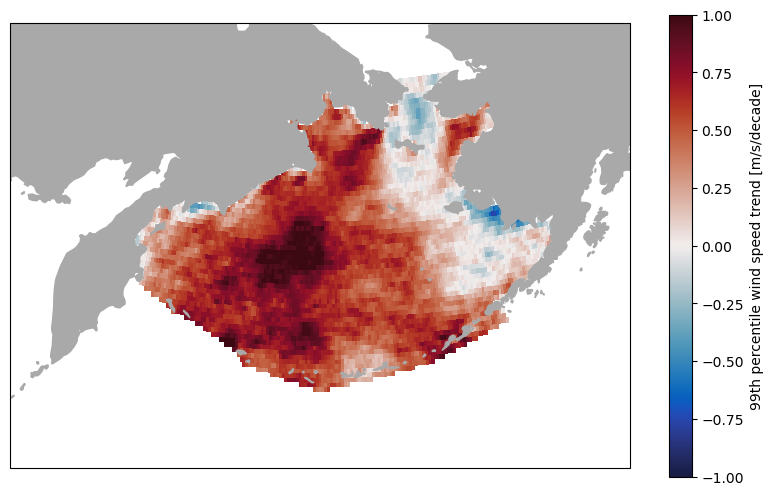

In [11]:
fig = plt.figure(figsize=(10,6))
ax=plt.axes(projection=projection)
ax.set_extent(region)

pc=ax.pcolormesh(ds['longitude'],ds['latitude'],da_trend,shading='auto', vmin=-1, vmax=1, cmap='cmo.balance', transform=ccrs.PlateCarree())
ax.add_feature(cfeature.LAND, zorder=2, color='darkgrey')

fig.colorbar(pc, label='99th percentile wind speed trend [m/s/decade]')

## Hypothesis testing
Stats.linregress computes the slope and intercept of the best linear fit, but also does a (two-sided) significance test compared to a null-hypothesis where the slope is zero. We test whether the (estimated) slope is significantly different from zero, assuming that the standard error of the slope is the same.

To test this hypothesis, we assume that if the null hypothesis (H0: slope = 0) is true, the slopes we calculate are samples from a t-distribution with a mean of zero. The t-value is related to the standard error of the slope. The p-value is then the probability to obtain the observed slope or a more extreme value from this t-distribution.

In [12]:
print(slopes[maxid])
print(std_errs[maxid])

0.115731576331576
0.03129727442059763


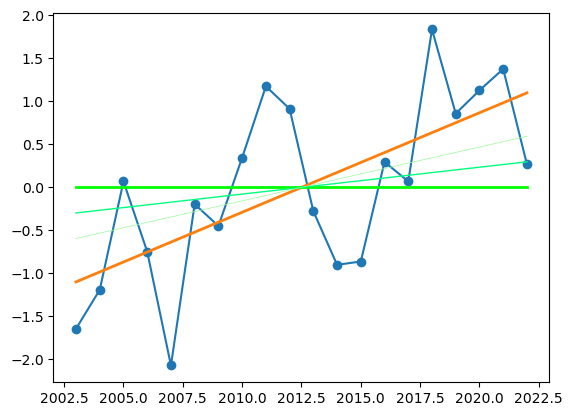

In [13]:
plt.scatter(x,y[:,maxid[0],maxid[1]]-np.mean(y[:,maxid[0],maxid[1]]))
plt.plot(x,y[:,maxid[0],maxid[1]]-np.mean(y[:,maxid[0],maxid[1]]))
plt.plot(x,slopes[maxid]*x+intercepts[maxid]-np.mean(y[:,maxid[0],maxid[1]]),linewidth=2)
plt.plot(x,np.zeros(x.shape),color='lime',linewidth=2)
plt.plot(x,std_errs[maxid]*x-np.mean(std_errs[maxid]*x),color='springgreen',linewidth=1)
plt.plot(x,2*std_errs[maxid]*x-np.mean(2*std_errs[maxid]*x),color='palegreen',linewidth=0.5)

(array([   7.,   33.,  122.,  477.,  785.,  729., 1396., 1634.,  611.,
         163.]),
 array([-0.07603166, -0.05685534, -0.03767901, -0.01850269,  0.00067363,
         0.01984996,  0.03902628,  0.05820261,  0.07737893,  0.09655525,
         0.11573158]),
 <BarContainer object of 10 artists>)

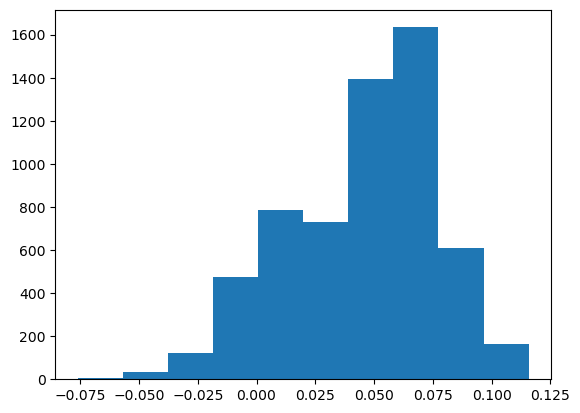

In [33]:
plt.hist(slopes[~np.isnan(slopes)])

In [15]:
x_slopes=np.linspace(2*slopes[minid],2*slopes[maxid])
y_ho=stats.norm.pdf(x_slopes, loc=0, scale=std_errs[maxid])
y_ha=stats.norm.pdf(x_slopes, loc=slopes[maxid], scale=std_errs[maxid])

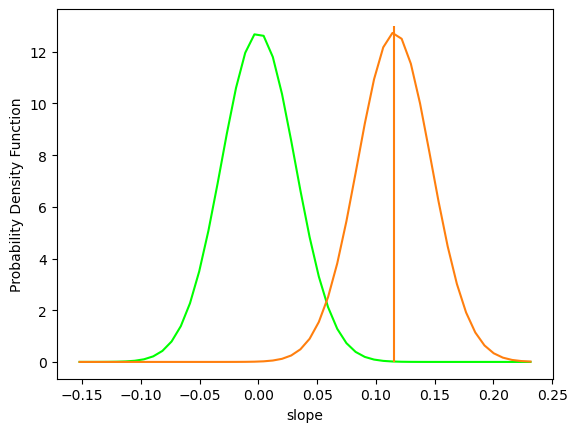

In [16]:
plt.plot(x_slopes,y_ho, color='lime')
plt.vlines(slopes[maxid],0,13,color='tab:orange')
plt.plot(x_slopes,y_ha, color='tab:orange')
plt.xlabel('slope')
plt.ylabel('Probability Density Function')
plt.show()

In [17]:
n=len(x)
df = n-2
SSY = np.sum(np.square(y_max-y_hat_max))
msxym = np.mean((x-np.mean(x))*(y_max-np.mean(y_max)))
msym = np.mean(np.square(y_max-np.mean(y_max)))
ssxm = np.sum(np.square(x-np.mean(x)))
msxm = np.mean(np.square(x-np.mean(x)))
SE = np.sqrt(1/df*SSY/ssxm)

In [18]:
r = msxym / np.sqrt(msxm * msym)

In [19]:
# t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
t = r * np.sqrt(df / ((1.0 - r)*(1.0 + r)))
t

3.6978159458406097

In [34]:
sp = SE**2*(n-1)/(n-2)

In [35]:
sp

0.0010339371298352523

In [36]:
SE

0.031297274420621884

In [40]:
T0 = (slopes[maxid]-0)/sp/np.sqrt(1/n)

In [41]:
T0

500.5791248871086

In [20]:
x_t = np.linspace(-4,4)
y_t = stats.t.pdf(x_t, df)

Text(0.5, 0, 't-value')

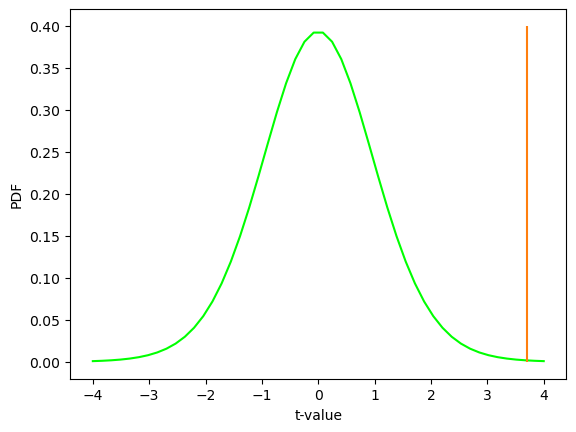

In [21]:
plt.plot(x_t,y_t, color='lime')
plt.vlines(t,0,0.4, color='tab:orange')
plt.ylabel('PDF')
plt.xlabel('t-value')

In [22]:
1-stats.t.cdf(t,df=df)

0.0008233247230732266

In [23]:
print(p_values[maxid])

0.0016466475809802132


In [24]:
da_pvalues = xr.DataArray(data=p_values,
                        dims=["latitude", "longitude"],
                        coords=dict(longitude=("longitude",ds["longitude"].data),
                                    latitude=("latitude",ds["latitude"].data)))

## Field Significance
In this case we have computed the trend at n x m = 11550 gridpoints. Because these gridpoints are geographically close to each other, the trends are not independent of each other. This spatial dependence needs to be taken into account when testing for the significance. 

Typically, we consider a single trend to be significant when the p-value testing the null-hypothesis is smallar than alpha = 0.05. This means that if the test were repeated on *N* samples of independent and normally distributed variables, 5% of those samples would exceed the significance threshold. When testing 11550 hypotheses at the same time, we can expect to find 11550 x 0.05 = 577.5 tests to randomly show a 5% significant trend. 

To take this into account, we can perform further tests to estimate whether these gridpoints are randomly or truly significant. Here, we start with the approach to control the **False Discovery Rate**.

<!-- Furthermore, these 11550 different *'samples'* of the 99th percentile of the wind speed are not independent.  -->
<!-- In [DelSole and Tippett, 2022](#Sources), -->

### False Discovery Rate
The False Discovery Rate (FDR), is defined as the expected fraction of tests that are erroneously considered significant. We can choose to accept for example that 10% of our tests are falsely determined significant. 

The procedure to control for this rate is relatively simple. Instead of considering whether individual tests have a p-value < 5%, we sort the p-values in ascending order and consider those tests where the p-value < 10% x *s*, where s is the number of the ordered grid point (see figure below).

In [25]:
sort_ids = np.argsort(p_values.ravel())
reverse_sort_ids = np.argsort(sort_ids)

In [26]:
sorted_pvalues = p_values.ravel()[sort_ids]#[~np.isnan(p_values[sort_ids])]
sorted_pvalues_clean = sorted_pvalues[~np.isnan(sorted_pvalues)]

In [27]:
S = len(sorted_pvalues_clean)
s = np.arange(1,len(sorted_pvalues)+1)
gamma = 0.1
BH_list_01 = s*gamma/S
BH_list_02 = s*gamma*2/S

(-0.01, 0.15)

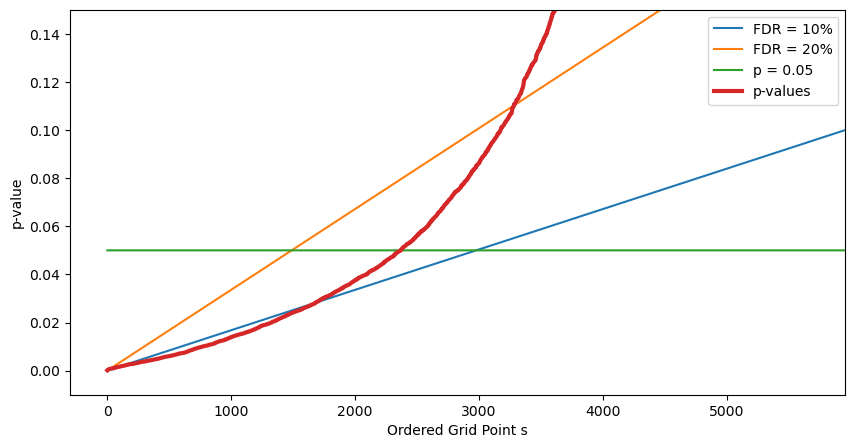

In [28]:
fig = plt.figure(figsize=(10,5))
ax=plt.axes()
ax.plot(s, BH_list_01, label='FDR = 10%')
ax.plot(s, BH_list_02, label='FDR = 20%')
ax.plot(s, np.ones(len(s))*0.05, label='p = 0.05')
ax.plot(s, sorted_pvalues, lw=3, label='p-values')

ax.set_xlabel('Ordered Grid Point s')
ax.set_ylabel('p-value')
ax.legend()
ax.set_xlim(-S*0.05, S)
ax.set_ylim(-0.01, 0.15)

In the figure above, we see how the **p-values** (**red**) would be considered significant compared to *a fixed value of 0.05* (*green*), and FDRs of *10%* (*blue*) and *20%* (*orange*). p-values below those lines are considered significant.

We can see that a FDR of 10% considers many tests insignificant which would be significant under the fixed p < 0.05 criterion. Conversely, when we would accept 20% of the tests to be falsely detected (orange), more tests would be considered significant

#### Mask significant p-values, slopes

In [29]:
FDR_10_bool_sorted = sorted_pvalues<BH_list_01
FDR_10_bool = FDR_10_bool_sorted[reverse_sort_ids]
FDR_10_bool = FDR_10_bool.reshape(p_values.shape[0],p_values.shape[1])

FDR_20_bool_sorted = sorted_pvalues<BH_list_02
FDR_20_bool = FDR_20_bool_sorted[reverse_sort_ids]
FDR_20_bool = FDR_20_bool.reshape(p_values.shape[0],p_values.shape[1])

In [30]:
trend_masked_10 = np.ma.masked_array(da_trend.data, mask=~FDR_10_bool)
trend_masked_20 = np.ma.masked_array(da_trend.data, mask=~FDR_20_bool)
trend_masked_fixed = np.ma.masked_array(da_trend.data, mask=p_values>0.05)

### Show significant trends

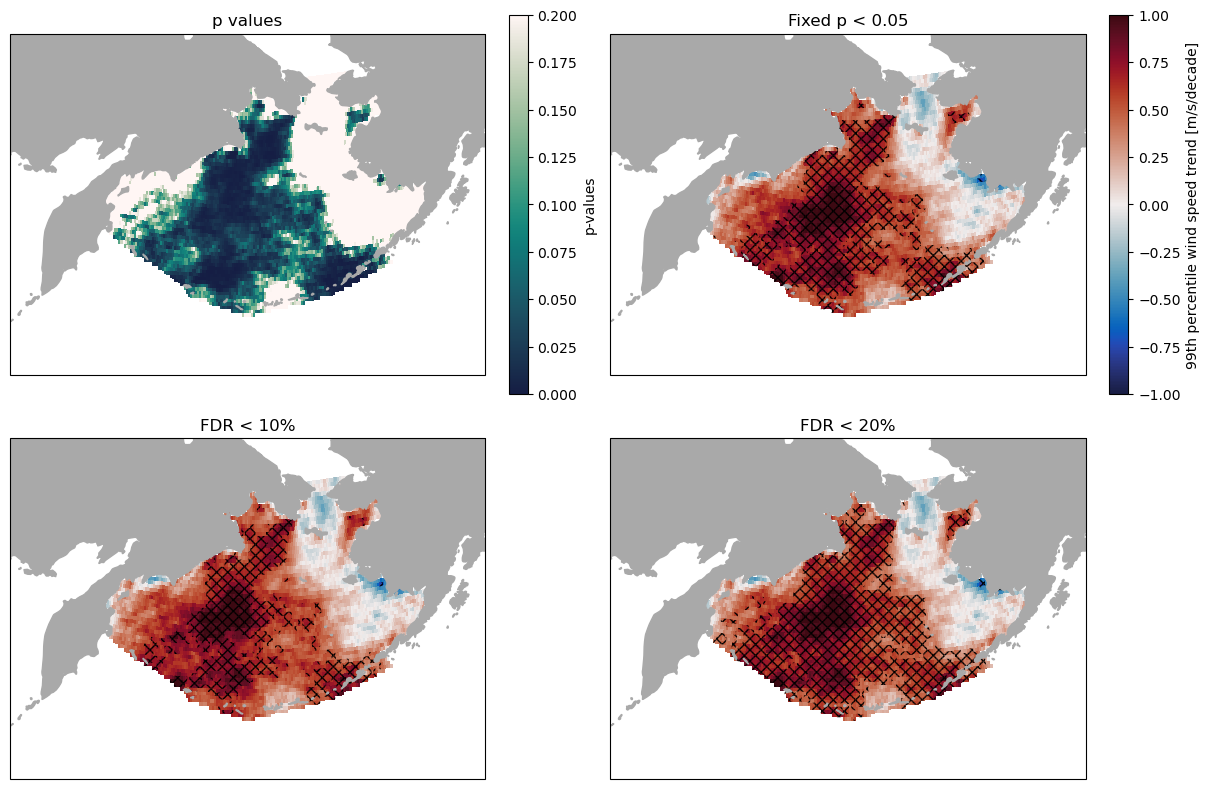

In [31]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(12,8), subplot_kw=dict(projection=ccrs.Stereographic(central_longitude=180)), constrained_layout=True)

ax1.set_title('p values')
ax1.set_extent((155,205,45,68))
pc1=ax1.pcolormesh(da_trend['longitude'],da_trend['latitude'],p_values, shading='auto', vmin=0., vmax=0.2, cmap='cmo.tempo_r', transform=ccrs.PlateCarree())
ax1.add_feature(cfeature.LAND, zorder=2, color='darkgrey')

ax2.set_title('Fixed p < 0.05')
ax2.set_extent((155,205,45,68))
pc2=ax2.pcolormesh(da_trend['longitude'],da_trend['latitude'],da_trend,shading='auto', vmin=-1, vmax=1, cmap='cmo.balance', transform=ccrs.PlateCarree())
ax2.pcolor(da_trend['longitude'], da_trend['latitude'], trend_masked_fixed, hatch='xxx', alpha=0., transform=ccrs.PlateCarree())
ax2.add_feature(cfeature.LAND, zorder=2, color='darkgrey')

ax3.set_title('FDR < 10%')
ax3.set_extent((155,205,45,68))
pc3=ax3.pcolormesh(da_trend['longitude'],da_trend['latitude'],da_trend,shading='auto', vmin=-1, vmax=1, cmap='cmo.balance', transform=ccrs.PlateCarree())
ax3.pcolor(da_trend['longitude'], da_trend['latitude'], trend_masked_10, hatch='xxx', alpha=0., transform=ccrs.PlateCarree())
ax3.add_feature(cfeature.LAND, zorder=2, color='darkgrey')

ax4.set_title('FDR < 20%')
ax4.set_extent((155,205,45,68))
pc4=ax4.pcolormesh(da_trend['longitude'],da_trend['latitude'],da_trend,shading='auto', vmin=-1, vmax=1, cmap='cmo.balance', transform=ccrs.PlateCarree())
ax4.pcolor(da_trend['longitude'], da_trend['latitude'], trend_masked_20, hatch='xxx', alpha=0., transform=ccrs.PlateCarree())
ax4.add_feature(cfeature.LAND, zorder=2, color='darkgrey')

fig.colorbar(pc2, label='99th percentile wind speed trend [m/s/decade]')
fig.colorbar(pc1, label='p-values')